In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from coherenceModel import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
paragraph_df = pd.read_csv('aviationPerms.csv')
paragraph_df

,paragraph,is_coherent
0,The preflight inspection of the fuel tanks by ...,1
1,"The pilot reported that he was cleared to 4,00...",1
2,The instrument-rated private pilot lost contro...,1
3,The non-instrument rated private pilot was rec...,1
4,The commercial pilot reported a partial power ...,1
...,...,...
2095,THE FUEL SELECTOR WAS POSITIONED ON THE RIGHT ...,0
2096,DURING AN INTENTIONAL MANEUVER TO AVOID A HOME...,0
2097,RESIDUAL FUEL WAS FOUND IN THE CARBURETOR BOWL...,0
2098,"AT A 75% POWER SETTING, FUEL FLOW IS ABOUT 10....",0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    paragraph_df.paragraph.values, 
    paragraph_df.is_coherent.values,
    stratify = paragraph_df.is_coherent.values,
    test_size = 0.1, 
    random_state = 487
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 487
)
print(X_train[0])
print(y_train[0])

Routine air work was performed and then touch-and-go landing practice was planned. The approach and landing on runway 34 was normal. During the takeoff roll the pilot noticed that unusual stick forces were required to raise the tail wheel. FAA inspectors examined the airplane and did not report finding any trim or control system irregularity; however, the fuselage distortion precluded a complete examination. He saw a row of sailplanes parked on runway 30 in his path and elected to turn off the runway into sagebrush and grass. He decided to abort the takeoff and applied forward stick to prevent the airplane from leaping off the runway in a stalled condition. The trim setting was rechecked and confirmed. The pilot added some additional nose down trim, but no relief of stick pressure was noticed. He was drifting to the right and approaching the intersection of runway 30 at this time. The right main landing gear fell into a ditch and collapsed, buckling and distorting the fuselage. Trim wa

In [5]:
embed = KeyedVectors.load('vectors.kv')

In [6]:
train_data = WindowedParDataset(X_train, y_train, embed, 3)
dev_data = WindowedParDataset(X_val, y_val, embed, 3)
test_data = WindowedParDataset(X_test, y_test, embed, 3)

In [26]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=False)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 104-- batch loss = 0.2888
Validation accuracy: 0.5000
Validation loss: 0.1898
Epoch No. 2--Iteration No. 208-- batch loss = 0.1513
Validation accuracy: 0.5000
Validation loss: 0.1810
Epoch No. 3--Iteration No. 312-- batch loss = 0.0205
Validation accuracy: 0.5000
Validation loss: 0.1907
Epoch No. 4--Iteration No. 416-- batch loss = 0.0320
Validation accuracy: 0.5000
Validation loss: 0.1585
Epoch No. 5--Iteration No. 520-- batch loss = 0.1089
Validation accuracy: 0.5000
Validation loss: 0.1526
Epoch No. 6--Iteration No. 624-- batch loss = 0.0499
Validation accuracy: 0.5000
Validation loss: 0.1530
Epoch No. 7--Iteration No. 728-- batch loss = 0.2826
Validation accuracy: 0.5000
Validation loss: 0.1436
Epoch No. 8--Iteration No. 832-- batch loss = 0.1498
Validation accuracy: 0.5000
Validation loss: 0.1435
Epoch No. 9--Iteration No. 936-- batch loss = 0.0634
Validation accuracy: 0.5000
Validation los

Validation accuracy: 0.9302
Validation loss: 0.0297
Epoch No. 78--Iteration No. 8112-- batch loss = 0.0701
Validation accuracy: 0.9401
Validation loss: 0.0272
Epoch No. 79--Iteration No. 8216-- batch loss = 0.0306
Validation accuracy: 0.9164
Validation loss: 0.0238
Epoch No. 80--Iteration No. 8320-- batch loss = 0.0311
Validation accuracy: 0.9103
Validation loss: 0.0253
Epoch No. 81--Iteration No. 8424-- batch loss = 0.0011
Validation accuracy: 0.9225
Validation loss: 0.0209
Epoch No. 82--Iteration No. 8528-- batch loss = 0.0002
Validation accuracy: 0.9042
Validation loss: 0.0266
Epoch No. 83--Iteration No. 8632-- batch loss = 0.0530
Validation accuracy: 0.9435
Validation loss: 0.0203
Epoch No. 84--Iteration No. 8736-- batch loss = 0.0077
Validation accuracy: 0.9375
Validation loss: 0.0199
Epoch No. 85--Iteration No. 8840-- batch loss = 0.0031
Validation accuracy: 0.9492
Validation loss: 0.0220
Epoch No. 86--Iteration No. 8944-- batch loss = 0.0030
Validation accuracy: 0.9606
Validatio

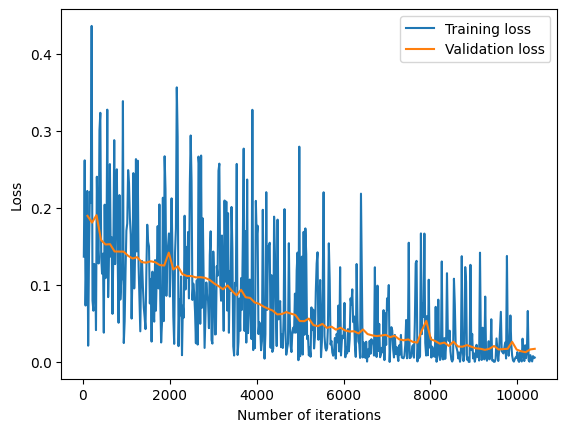

In [31]:
# test on validation to see if overfit is possible
ffnn = FFNN(256, 200, False, 3, device)
ffnn.to(device)
optim = get_optimizer(ffnn, lr=1e-3, weight_decay=0)
best_model, stats = train_model(ffnn, dev_loader, dev_loader, optim,
                                num_epoch=100, collect_cycle=20, device=device, patience=None)
plot_loss(stats)

In [ ]:
import itertools
from tqdm.notebook import tqdm
from qa import get_hyper_parameters

def search_param_utterance():
    """Experiemnt on different hyper parameters."""
    hidden_dim, learning_rate, weight_decay, window_sizes = get_hyper_parameters()
    print("hidden dimension from: {}\nlearning rate from: {}\nweight_decay from: {}".format(
        hidden_dim, learning_rate, weight_decay
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_hd = 0, 0, 0, 0
    for hd, lr, wd, window_size in tqdm(itertools.product(hidden_dim, learning_rate, weight_decay, window_sizes),
                           total=len(hidden_dim) * len(learning_rate) * len(weight_decay) * len(window_sizes)):
        net = FFNN(hd, 200, False, 3, device).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, num_epoch=50,
                                   collect_cycle=500, device=device, verbose=False, patience=10)
        # print accuracy
        print(f"{(hd, lr, wd)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_hd, best_lr, best_wd, best_window_size = hd, lr, wd, window_size
    print("\n\nBest hidden dimension: {}, Best learning rate: {}, best weight_decay: {}".format(
        best_hd, best_lr, best_wd))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param_utterance()